<a href="https://colab.research.google.com/github/narevignesh/Multi-class-animal-recognition/blob/main/Multi_class_animal_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%
# Purpose: Install necessary libraries for the project.
# Result: Installs the specified libraries and their dependencies.
!pip install kaggle
!pip install ipython
!pip install matplotlib
!pip install numpy
!pip install tensorflow
!pip install scikit-learn
!pip install Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.1 MB/s eta 0:00:00


In [2]:
# %%
# Purpose: Import necessary libraries for interacting with the notebook and displaying content.
# Result: Makes the functionalities of IPython and display available for use in the notebook.
from IPython import get_ipython
from IPython.display import display

In [3]:
# %%
# Purpose: Download the animal image dataset from Kaggle.
# Result: Downloads the dataset and prints the path to the downloaded files.
import kagglehub

path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals


In [4]:
# %%
# Purpose: Import necessary libraries for data processing, visualization, and model building.
# Result: Makes the functionalities of the imported libraries available for use in the notebook.
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
# %%
# Purpose: Check and print the number of available GPUs.
# Result: Prints the number of available GPUs and the name of the GPU if available.
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

if tf.config.list_physical_devices('GPU'):
    print("GPU Name:", tf.config.list_physical_devices('GPU')[0].name)

Num GPUs Available:  1
GPU Name: /physical_device:GPU:0


In [6]:
# %%
# Purpose: Define the dataset path and retrieve class information.
# Result: Sets the dataset path and prints the class names and the number of classes.
dataset_path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"
classes = os.listdir(dataset_path)
num_classes = len(classes)
print("Classes:", classes)
print("Number of classes:", num_classes)

Classes: ['beetle', 'parrot', 'fox', 'wolf', 'hedgehog', 'turtle', 'snake', 'shark', 'horse', 'antelope', 'hamster', 'woodpecker', 'eagle', 'chimpanzee', 'bison', 'penguin', 'butterfly', 'sandpiper', 'hornbill', 'lion', 'lobster', 'oyster', 'otter', 'grasshopper', 'raccoon', 'dog', 'pigeon', 'donkey', 'hippopotamus', 'hummingbird', 'bear', 'coyote', 'bee', 'pig', 'rat', 'owl', 'caterpillar', 'koala', 'squid', 'hare', 'whale', 'mouse', 'tiger', 'fly', 'lizard', 'orangutan', 'bat', 'porcupine', 'kangaroo', 'gorilla', 'starfish', 'mosquito', 'crow', 'possum', 'goldfish', 'swan', 'elephant', 'sheep', 'dragonfly', 'zebra', 'seal', 'octopus', 'cow', 'ox', 'wombat', 'reindeer', 'panda', 'duck', 'goose', 'goat', 'badger', 'flamingo', 'crab', 'seahorse', 'rhinoceros', 'dolphin', 'okapi', 'moth', 'sparrow', 'pelecaniformes', 'squirrel', 'leopard', 'jellyfish', 'ladybugs', 'cockroach', 'hyena', 'cat', 'deer', 'turkey', 'boar']
Number of classes: 90


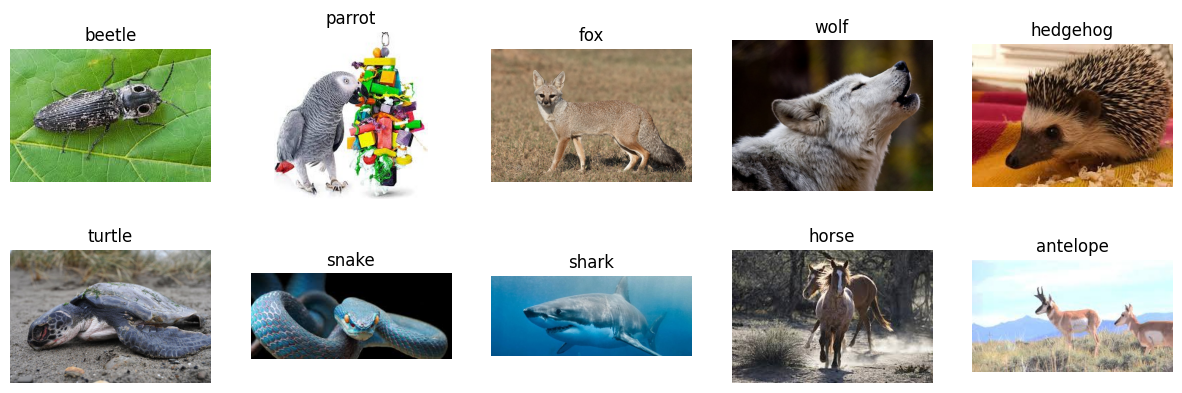

In [7]:
# %%
# Purpose: Display sample images from the dataset.
# Result: Generates a plot containing sample images from the first 10 classes, with their corresponding class names as titles.
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(classes[:10]):
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)[0]
    image_path = os.path.join(class_path, image_files)
    image = Image.open(image_path)

    plt.subplot(4, 5, i + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')


plt.show()

In [8]:
# %%
# Purpose: Preprocess the data using ImageDataGenerator.
# Result: Creates training and validation data generators for loading and augmenting images.
# Define image size and batch_size - Trained model - MobileNetV2 - 224 x 224
img_size = (224, 224)
batch_size = 64 # There can be 64 images in a batch

# Data Augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

# Create training and validation generators
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 4860 images belonging to 90 classes.
Found 540 images belonging to 90 classes.


In [9]:
# %%
# Purpose: Get class indices and names.
# Result: Prints the class indices and class names.
class_indices = train_generator.class_indices
print(class_indices)

class_names = list(class_indices.keys())
print("Class Names:", class_names)

{'antelope': 0, 'badger': 1, 'bat': 2, 'bear': 3, 'bee': 4, 'beetle': 5, 'bison': 6, 'boar': 7, 'butterfly': 8, 'cat': 9, 'caterpillar': 10, 'chimpanzee': 11, 'cockroach': 12, 'cow': 13, 'coyote': 14, 'crab': 15, 'crow': 16, 'deer': 17, 'dog': 18, 'dolphin': 19, 'donkey': 20, 'dragonfly': 21, 'duck': 22, 'eagle': 23, 'elephant': 24, 'flamingo': 25, 'fly': 26, 'fox': 27, 'goat': 28, 'goldfish': 29, 'goose': 30, 'gorilla': 31, 'grasshopper': 32, 'hamster': 33, 'hare': 34, 'hedgehog': 35, 'hippopotamus': 36, 'hornbill': 37, 'horse': 38, 'hummingbird': 39, 'hyena': 40, 'jellyfish': 41, 'kangaroo': 42, 'koala': 43, 'ladybugs': 44, 'leopard': 45, 'lion': 46, 'lizard': 47, 'lobster': 48, 'mosquito': 49, 'moth': 50, 'mouse': 51, 'octopus': 52, 'okapi': 53, 'orangutan': 54, 'otter': 55, 'owl': 56, 'ox': 57, 'oyster': 58, 'panda': 59, 'parrot': 60, 'pelecaniformes': 61, 'penguin': 62, 'pig': 63, 'pigeon': 64, 'porcupine': 65, 'possum': 66, 'raccoon': 67, 'rat': 68, 'reindeer': 69, 'rhinoceros': 

In [10]:
# %%
# Purpose: Build and compile the model.
# Result: Creates and compiles the model for training.
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90)             │        92,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,661,978 (13.97 MB)

 Trainable params: 1,403,994 (5.36 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# %%
# Purpose: Train the model.
# Result: Trains the model and stores the training history.
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs = 20
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 548ms/step - accuracy: 0.9104 - loss: 0.3764 - val_accuracy: 0.8516 - val_loss: 0.5987
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9688 - loss: 0.3487 - val_accuracy: 0.8555 - val_loss: 0.6042
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 528ms/step - accuracy: 0.9215 - loss: 0.3415 - val_accuracy: 0.8516 - val_loss: 0.5753
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8750 - loss: 0.3762 - val_accuracy: 0.8535 - val_loss: 0.5756
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 547ms/step - accuracy: 0.9369 - loss: 0.2890 - val_accuracy: 0.8535 - val_loss: 0.5591
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.8906 - loss: 0.3652 - val_accuracy: 0.8516 - val_loss: 0.5645
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 77s 534ms/step - accuracy: 0.9402 - loss: 0.2661 - val_accuracy: 0.8633 - val_loss: 0.5323
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9219 - loss: 0.2285 - val_accuracy: 0.

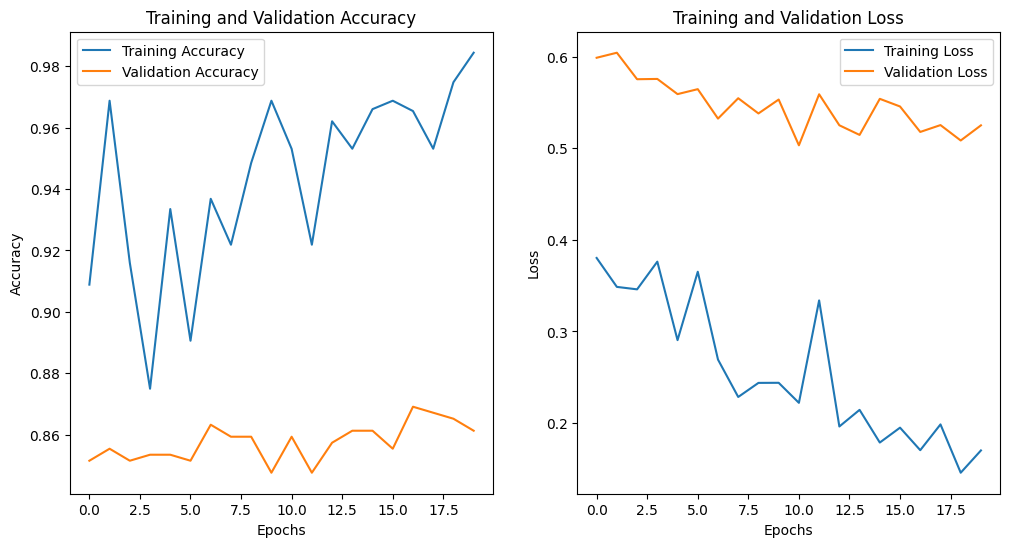

In [23]:
# %%
# Purpose: Plot training and validation accuracy/loss.
# Result: Generates plots showing the training and validation accuracy and loss over epochs.
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [24]:
# %%
# Purpose: Evaluate the model on the validation set.
# Result: Prints the validation loss and accuracy.
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 415ms/step - accuracy: 0.8736 - loss: 0.4748
Validation Loss: 0.5081634521484375
Validation Accuracy: 0.864814817905426


In [26]:
# %%
# Purpose: Save the trained model.
# Result: Saves the model to a file named 'MCAR.keras'.
model.save('MCAR.keras')

In [32]:
# %%
# Purpose: Load the saved model and define a prediction function.
# Result: Loads the model and defines a function to predict the animal in an image.
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array # Import load_img and img_to_array

model = load_model('MCAR.keras')

def predict_animal(img_path):
    img = load_img(img_path, target_size=(224, 224)) # Use load_img from keras.preprocessing.image
    img_array = img_to_array(img) # Use img_to_array from keras.preprocessing.image
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

In [35]:
# %%
# Purpose: List files in a specific directory.
# Result: Prints the list of files in the specified directory.
os.listdir('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/snake')

['38dcca56f9.jpg',
 '5649b831d8.jpg',
 '7701d7752e.jpg',
 '2e263a2559.jpg',
 '0c6f39489a.jpg',
 '0adeed6415.jpg',
 '60afeda678.jpg',
 '56ee3ca187.jpg',
 '207bf76d96.jpg',
 '6e6f16d262.jpg',
 '1088ac3e42.jpg',
 '117fedcf77.jpg',
 '2c5acd90f0.jpg',
 '3b6d6e861d.jpg',
 '50afc21ee1.jpg',
 '6307ae132f.jpg',
 '32d6a90818.jpg',
 '255c02e2c1.jpg',
 '6b4b318917.jpg',
 '27c00574e5.jpg',
 '9090f8d981.jpg',
 '3a00537173.jpg',
 '4ad3fbedde.jpg',
 '04a37e0cde.jpg',
 '81a1ff5ac8.jpg',
 '05c353dc52.jpg',
 '9ac132c555.jpg',
 '0dd9e55a78.jpg',
 '1407bc5b76.jpg',
 '29a9a8dd3e.jpg',
 '9b5d5ab8da.jpg',
 '3171e06ee3.jpg',
 '30e92dc7a1.jpg',
 '1c55460bfc.jpg',
 '4bf4f30634.jpg',
 '874e35fa86.jpg',
 '8bdaf65b8a.jpg',
 '7526fa488c.jpg',
 '91dd6e3269.jpg',
 '51e5b89cc5.jpg',
 '8dc203e3a9.jpg',
 '5e5560a3ea.jpg',
 '3ab9ac5706.jpg',
 '71e9faecff.jpg',
 '97ed7233a0.jpg',
 '41ea01f58c.jpg',
 '51e556629f.jpg',
 '1361b2aa41.jpg',
 '2bfed11a46.jpg',
 '2c76f7d316.jpg',
 '77bc1747df.jpg',
 '87c27d3f3f.jpg',
 '358b751986

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


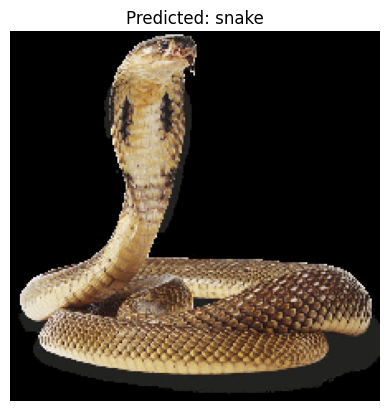

In [37]:
# %%
# Purpose: Predict the animal in an image using the predict_animal function.
# Result: Predicts the animal in the specified image and displays the image with the prediction.
predict_animal('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/snake/99b4143227.jpg')